In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm

plt.rcParams.update({
    "text.usetex": True,       
    "font.family": "serif",
    "figure.dpi": 110,        
    "figure.autolayout": True,
    "text.usetex": True,
})

DATA_DIR = Path(".")        
HIST_DIR = DATA_DIR / "model" 
OUT_DIR = Path("plots")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Data Preprocessing

In [101]:
import re

def build_tag(row) -> str:
    """Создаём tag точно так же, как в run_all.py"""
    aug = "aug" if bool(row["augmix"]) else "noaug"
    return (
        f"{row["dataset"]}_{row["model"]}_{row["loss"]}"
        f"_ls{row['ls']}_mx{row['mixup']}_{aug}"
    )

_num  = r"(?:[0-9]+(?:\.[0-9]+)?)"      # 0, 0.0, 0.2, 10, 10.25 …

PAT = re.compile(
    rf"^(?P<dataset>[^_]+)_"            # cifar10
    rf"(?P<model>[^_]+)_"               # resnet50
    rf"(?P<loss>.+?)_"                  # cross_entropy / dual_focal / bsce_gra
    rf"ls(?P<ls>{_num})_"               # ls0   или ls0.1
    rf"mx(?P<mixup>{_num})_"            # mx0.2
    rf"(?P<augmix>aug|noaug)$"          # aug | noaug
)

def parse_config(tag: str) -> dict:
    m = PAT.match(tag)
    if not m:
        raise ValueError(f"не удалось распарсить tag: {tag}")
    d = m.groupdict()
    d["ls"]     = float(d["ls"])
    d["mixup"]  = float(d["mixup"])
    d["augmix"] = d["augmix"] == "aug"
    return d

def method_group(loss, ls, mixup, augmix) -> str:
    """Правила категоризации"""
    baseline = (
        (loss == "cross_entropy")
        and ls == 0
        and mixup == 0
        and not augmix
    )
    if baseline:
        return "Baseline"

    parts = []
    if loss != "cross_entropy":
        parts.append("AltLoss")
    if (ls > 0) or (mixup > 0) or augmix:
        parts.append("RegAug")
    return "+".join(parts)

def regaug_group(ls, mixup, augmix) -> str:
    """Правила категоризации RegAug"""
    baseline = (ls == 0 and mixup == 0 and not augmix)
    if baseline:
        return "Baseline"
    elif ls:
        return "Label Smoothing"
    elif mixup:
        return "MixUp"
    elif augmix:
        return "AugMix"


# Для удобства приведём названия колонок к snake_case
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

In [102]:
test_df  = pd.read_csv(DATA_DIR / "test_master.csv")
test_df["accuracy"] = test_df["accuracy"] / 100.0
calib_df = pd.read_csv(DATA_DIR / "calib_master.csv")

histories = []
for csv_path in HIST_DIR.rglob("history.csv"):
    cfg_name = csv_path.parent.name                # имя папки == конфигу
    df = pd.read_csv(csv_path)
    df["config"] = cfg_name
    histories.append(df)

hist_df = pd.concat(histories, ignore_index=True)
hist_df.columns = [c.lower() for c in hist_df.columns]

test_df  = normalize_cols(test_df)
calib_df = normalize_cols(calib_df)


In [103]:
for df in (test_df, calib_df):
    if "config" not in df.columns:
        df["config"] = df.apply(build_tag, axis=1)

parsed = pd.DataFrame(hist_df["config"].apply(parse_config).tolist())
hist_df = pd.concat([hist_df, parsed], axis=1)


test_df["method"] = test_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

hist_df["method"] = hist_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

calib_df["method_group"] = "Post-hoc" + "+" + calib_df.apply(
                                            lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
                                        )

calib_df.rename(columns={"method": "calibrator"}, inplace=True)
calib_df.rename(columns={"method_group": "method"}, inplace=True)

rename_loss_dict = {
        "cross_entropy" : "Cross Entropy Loss",
        "focal" : "Focal Loss",
        "dual_focal" : "Dual Focal Loss",
        "bsce_gra" : "BSCE-GRA"
    }

for name, df in zip(['test_df', 'calib_df', 'hist_df'], [test_df, calib_df, hist_df]):
    df["RegAug"] = df.apply(
        lambda r: regaug_group(r["ls"], r["mixup"], r["augmix"]), axis=1
    )
    df['Mix Methods'] = df['RegAug'] + '+' + df['loss']
    df["loss"]    = df["loss"].replace(rename_loss_dict)
    df["dataset"] = df["dataset"].astype("category")
    df["method"]  = df["method"].astype("category")
    df["loss"]    = df["loss"].astype("category")
    df["RegAug"]  = df["RegAug"].astype("category")
    df['Mix Methods'] = df['Mix Methods'].astype("category")
    
    
    df = df[~((df['dataset'] == 'otto') & (df['RegAug'] == 'AugMix'))]
    df = df.reset_index(drop=True)
    locals()[name] = df

In [104]:
test_df.head()

dataset     model                loss   ls  mixup  augmix  accuracy  \
0  cifar10  resnet50  Cross Entropy Loss  0.0    0.0   False    0.7302   
1  cifar10  resnet50  Cross Entropy Loss  0.1    0.0   False    0.7749   
2  cifar10  resnet50  Cross Entropy Loss  0.0    0.2   False    0.7635   
3  cifar10  resnet50  Cross Entropy Loss  0.0    0.0    True    0.7545   
4  cifar10  resnet50          Focal Loss  0.0    0.0   False    0.7346   

        ece    adaece  classece     brier  \
0  0.010877  0.010893  0.012201  0.370983   
1  0.055479  0.055181  0.021709  0.326433   
2  0.042814  0.043310  0.020512  0.331881   
3  0.034155  0.033997  0.016736  0.339672   
4  0.113463  0.113201  0.027036  0.386456   

                                             config    method  \
0  cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug  Baseline   
1  cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug    RegAug   
2  cifar10_resnet50_cross_entropy_ls0.0_mx0.2_noaug    RegAug   
3    cifar10_resnet50_cross_entropy_ls0.0_mx0.0_aug    RegAug   
4          cifar10_resnet50_focal_ls0.0_mx0.0_noaug   AltLoss   

            RegAug                    Mix Methods  
0         Baseline         Baseline+cross_entropy  
1  Label Smoothing  Label Smoothing+cross_entropy  
2            MixUp            MixUp+cross_entropy  
3           AugMix           AugMix+cross_entropy  
4         Baseline                 Baseline+focal

In [105]:
calib_df.head()

dataset     model   calibrator                loss   ls  mixup  augmix  \
0  cifar10  resnet50  temperature  Cross Entropy Loss  0.0    0.0   False   
1  cifar10  resnet50        platt  Cross Entropy Loss  0.0    0.0   False   
2  cifar10  resnet50     isotonic  Cross Entropy Loss  0.0    0.0   False   
3  cifar10  resnet50          bbq  Cross Entropy Loss  0.0    0.0   False   
4  cifar10  resnet50  temperature  Cross Entropy Loss  0.1    0.0   False   

   accuracy       ece    adaece  classece     brier  \
0    0.7302  0.017131  0.014280  0.012098  0.371112   
1    0.7444  0.022046  0.022177  0.008598  0.351956   
2    0.7314  0.021234  0.024059  0.008671  0.365342   
3    0.1627  0.016893  0.021688  0.008641  0.877068   
4    0.7749  0.031609  0.030017  0.014888  0.324182   

                                             config             method  \
0  cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug  Post-hoc+Baseline   
1  cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug  Post-hoc+Baseline   
2  cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug  Post-hoc+Baseline   
3  cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug  Post-hoc+Baseline   
4  cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug    Post-hoc+RegAug   

            RegAug                    Mix Methods  
0         Baseline         Baseline+cross_entropy  
1         Baseline         Baseline+cross_entropy  
2         Baseline         Baseline+cross_entropy  
3         Baseline         Baseline+cross_entropy  
4  Label Smoothing  Label Smoothing+cross_entropy

In [106]:
hist_df.head()

epoch  train_loss  val_loss  val_acc   val_ece  val_adaece  val_classece  \
0      0   16.743919  2.375147     9.36  0.016933    0.017036      0.338464   
1      1    2.338861  2.349723     9.38  0.013266    0.017614      0.579440   
2      2    2.338044  2.323183    10.60  0.002015    0.014083      0.739342   
3      3    2.341838  2.338370     9.26  0.013709    0.013709      0.418616   
4      4    2.338008  2.338637     9.66  0.009713    0.011481      0.342305   

   val_brier                                       config  dataset     model  \
0   0.901285  cifar10_resnet50_dual_focal_ls0_mx0.2_noaug  cifar10  resnet50   
1   0.901034  cifar10_resnet50_dual_focal_ls0_mx0.2_noaug  cifar10  resnet50   
2   0.899932  cifar10_resnet50_dual_focal_ls0_mx0.2_noaug  cifar10  resnet50   
3   0.900758  cifar10_resnet50_dual_focal_ls0_mx0.2_noaug  cifar10  resnet50   
4   0.900643  cifar10_resnet50_dual_focal_ls0_mx0.2_noaug  cifar10  resnet50   

              loss   ls  mixup  augmix          method RegAug  \
0  Dual Focal Loss  0.0    0.2   False  AltLoss+RegAug  MixUp   
1  Dual Focal Loss  0.0    0.2   False  AltLoss+RegAug  MixUp   
2  Dual Focal Loss  0.0    0.2   False  AltLoss+RegAug  MixUp   
3  Dual Focal Loss  0.0    0.2   False  AltLoss+RegAug  MixUp   
4  Dual Focal Loss  0.0    0.2   False  AltLoss+RegAug  MixUp   

        Mix Methods  
0  MixUp+dual_focal  
1  MixUp+dual_focal  
2  MixUp+dual_focal  
3  MixUp+dual_focal  
4  MixUp+dual_focal

# Plots
Для начала сравним бейслайн со всеми другими методами в без конкретизации

In [107]:
history_val_metrics_cols = ['val_loss', 'val_acc', 'val_ece', 'val_adaece', 'val_classece', 'val_brier']

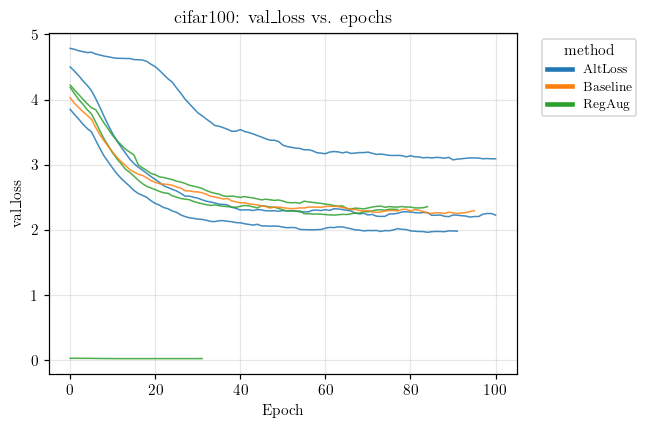

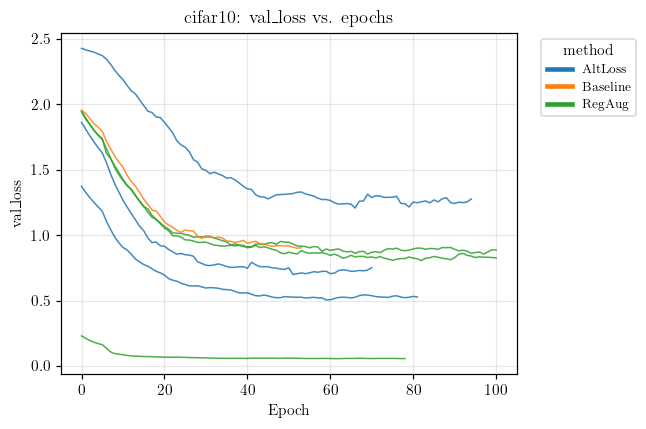

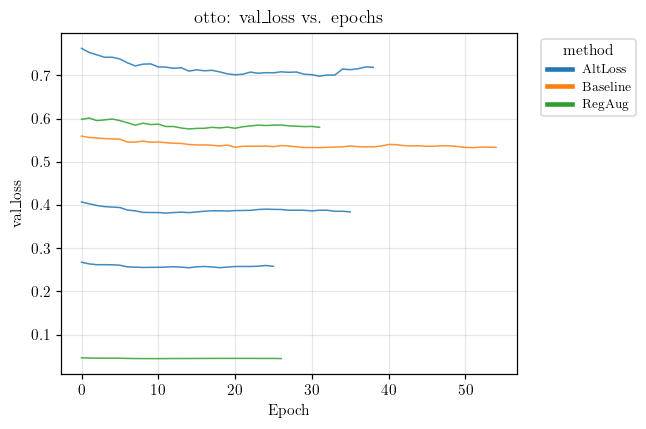

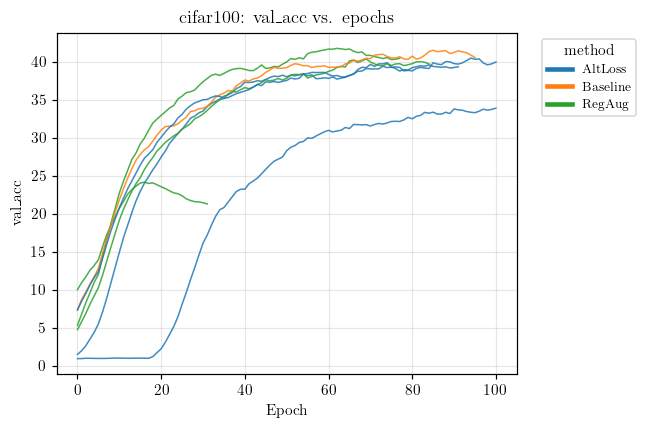

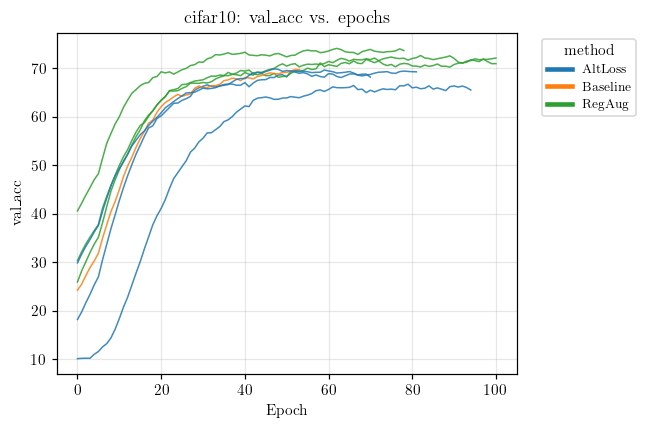

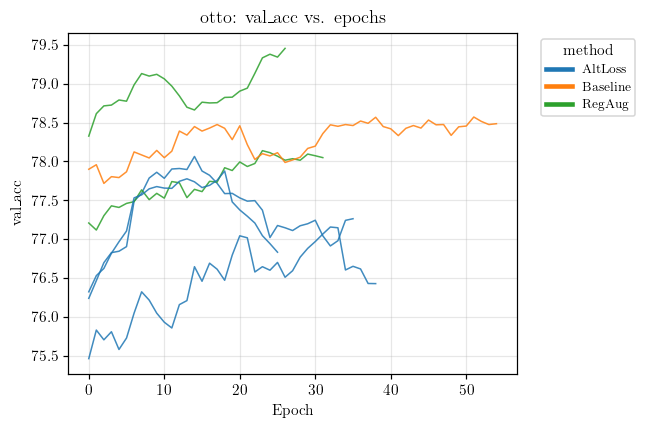

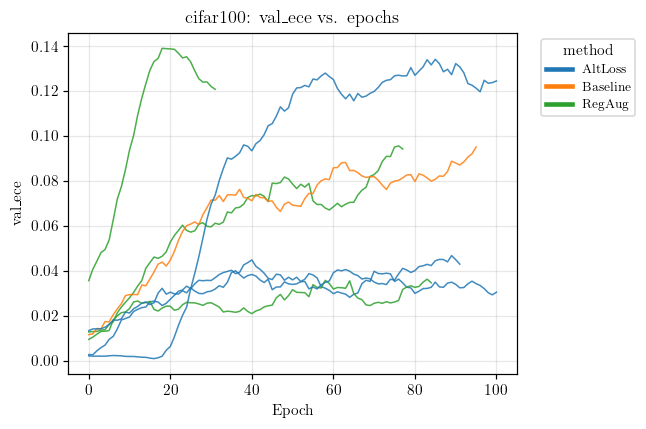

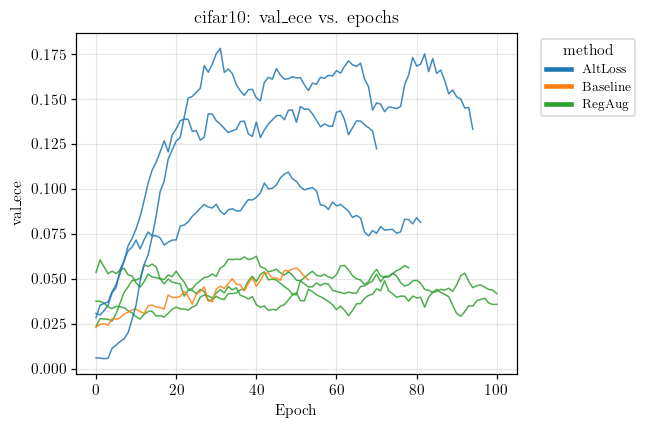

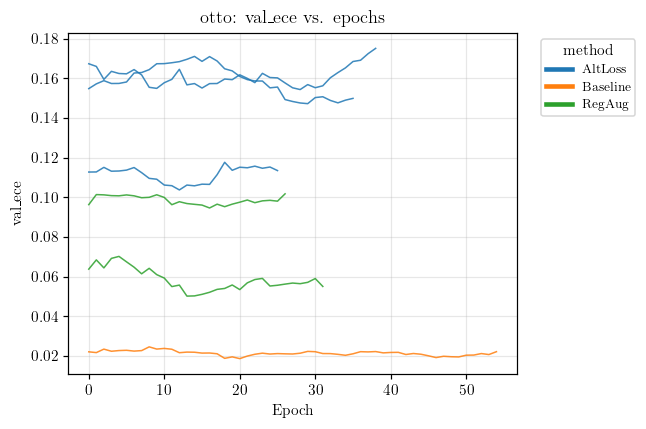

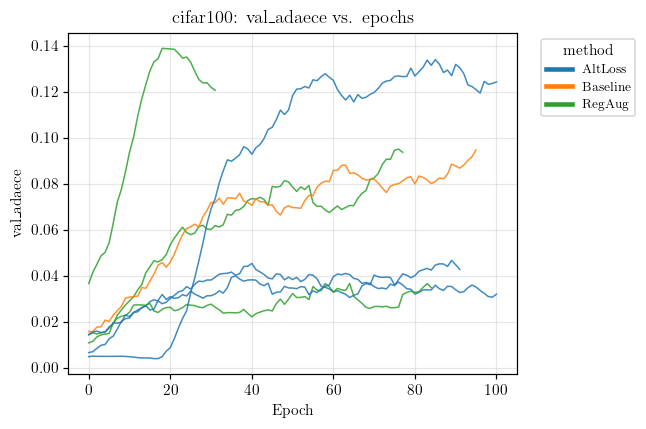

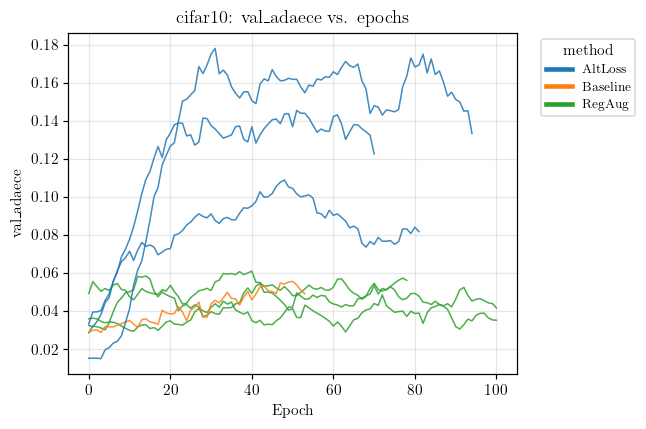

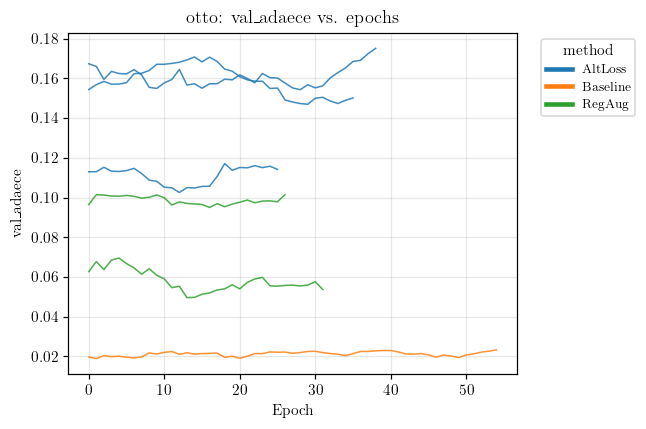

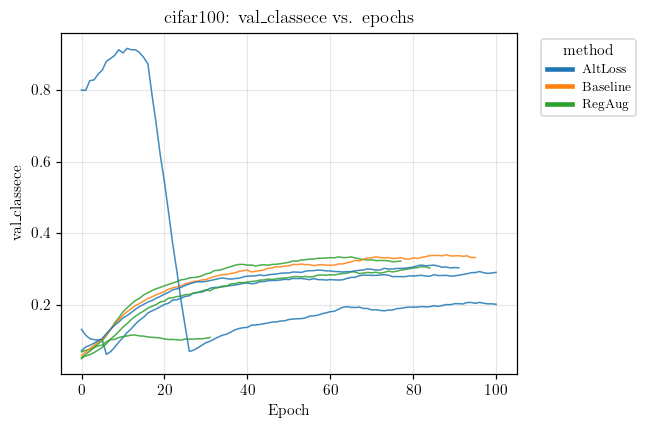

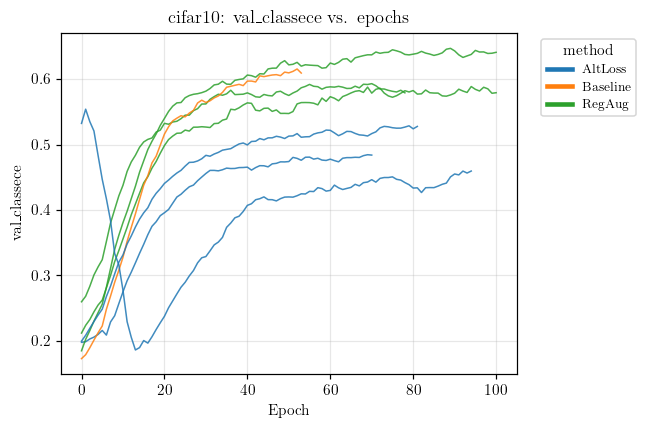

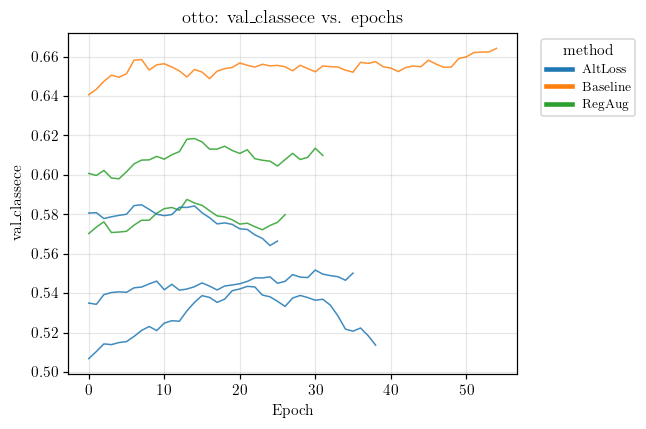

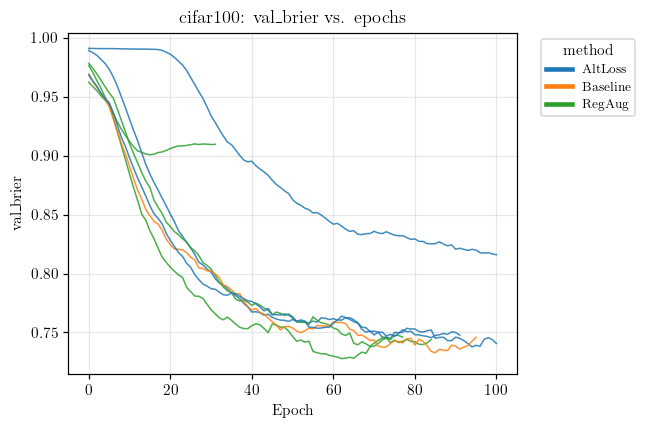

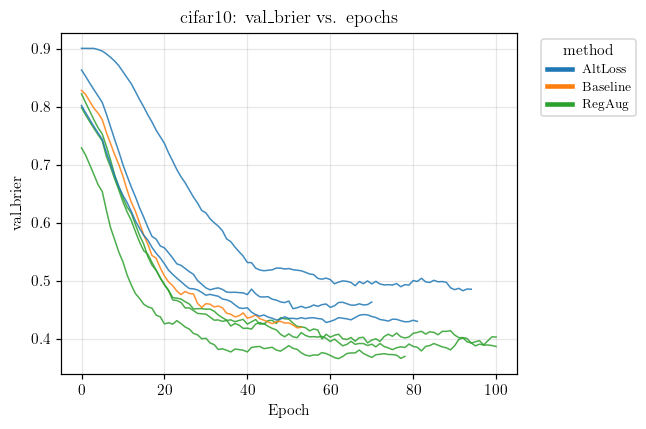

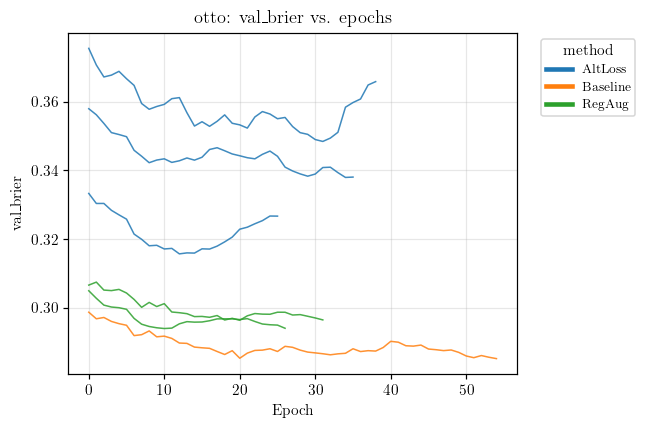

In [55]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'aggregated'

mask = hist_df['method'].isin(['Baseline', 'AltLoss', 'RegAug'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, save_pdf=True, path_to_dir=aggregated_path)

Начинаем смотреть по каждому методу по отдельности

AltLoss

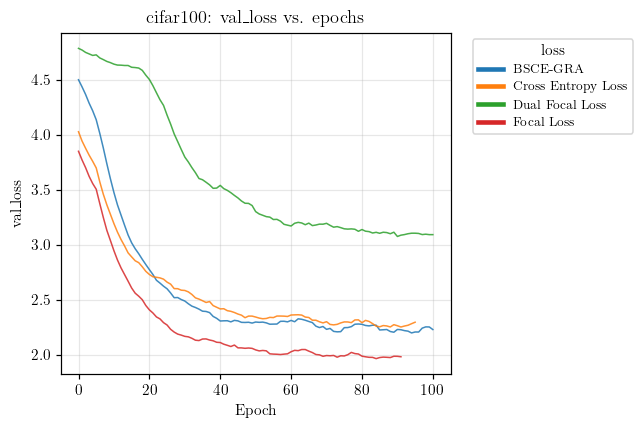

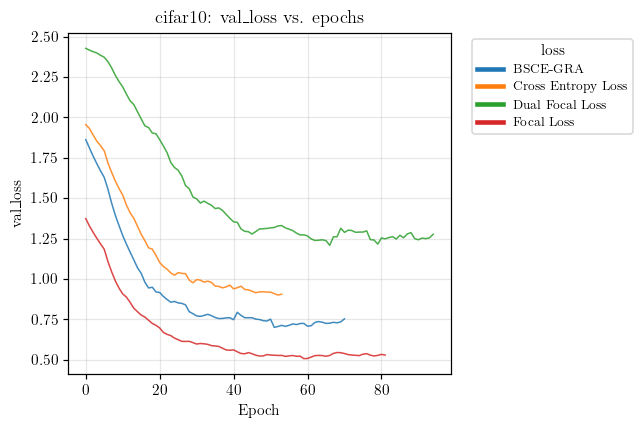

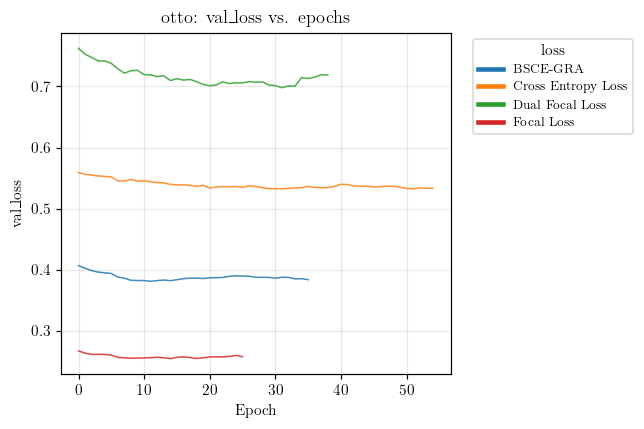

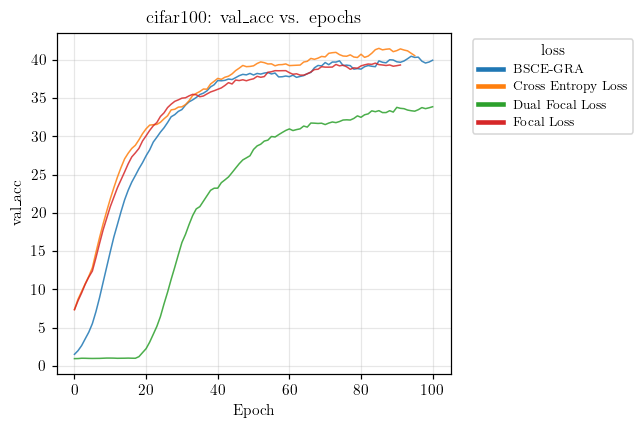

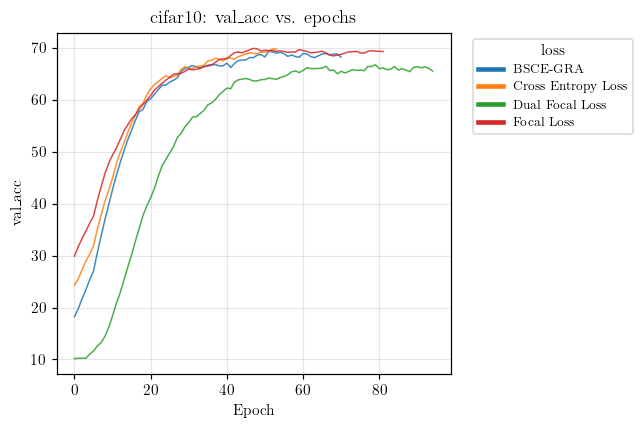

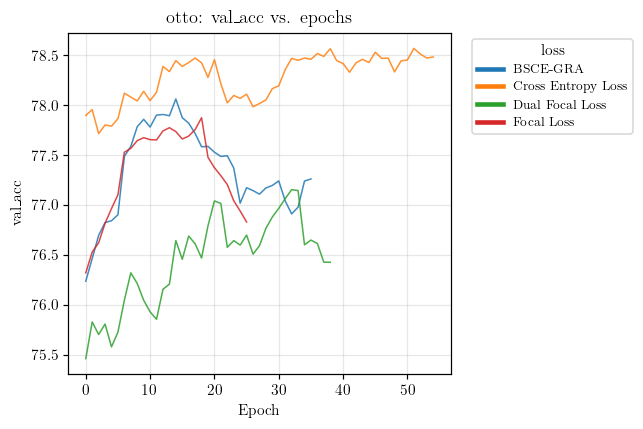

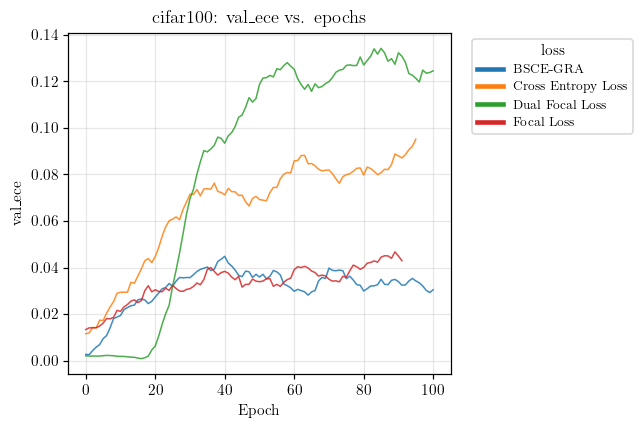

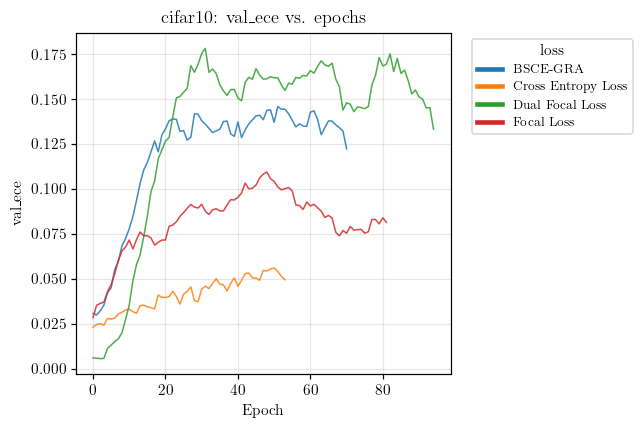

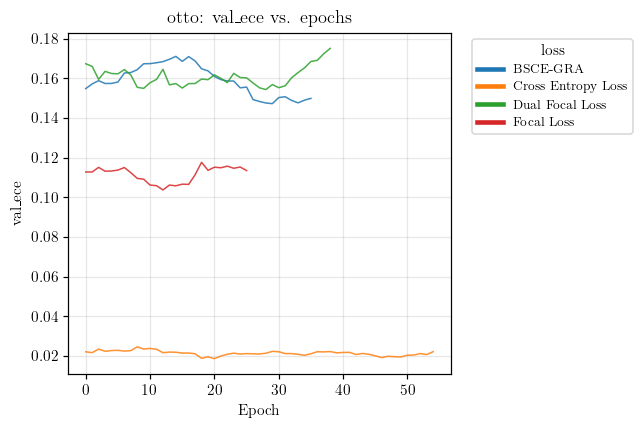

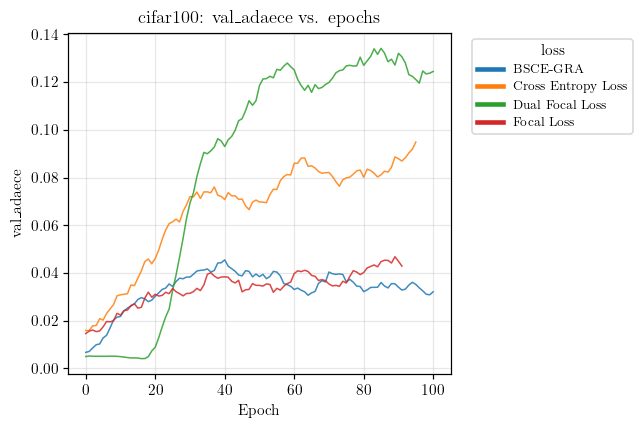

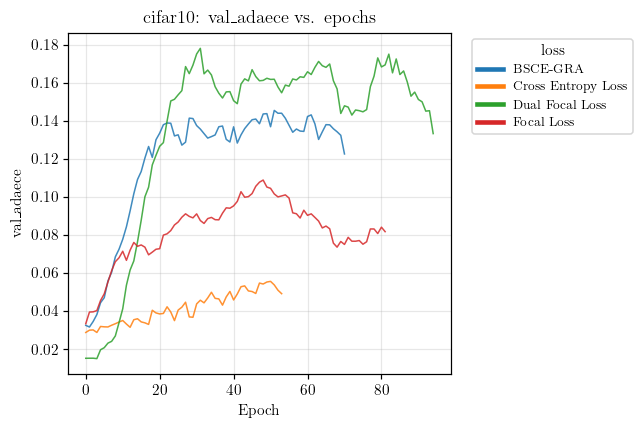

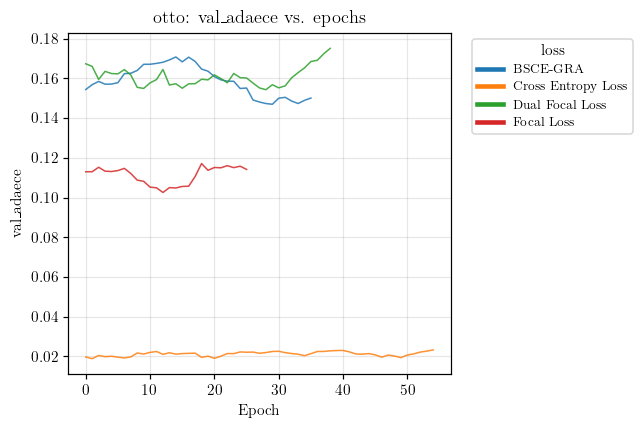

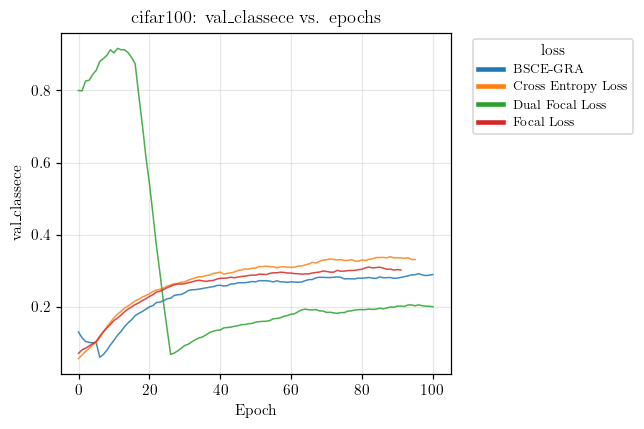

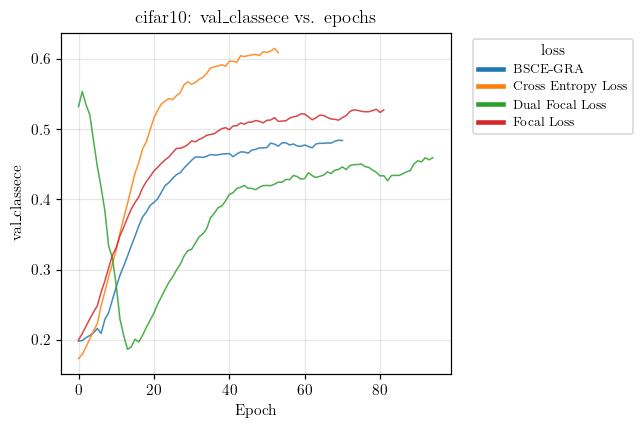

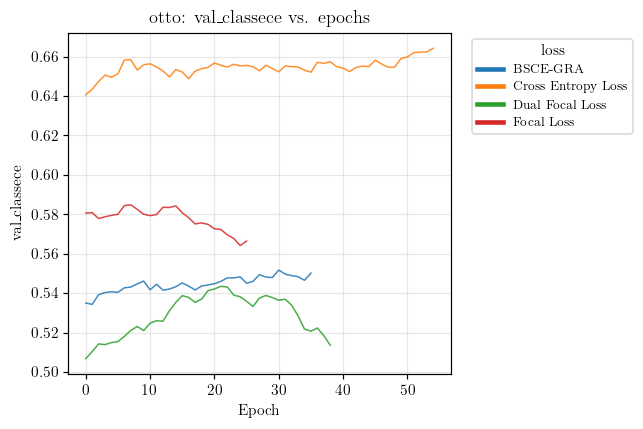

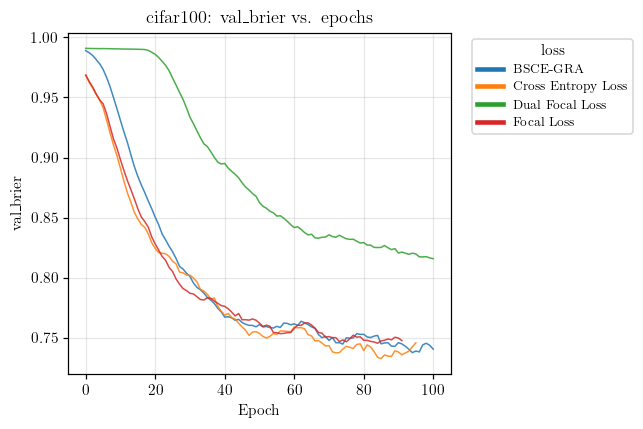

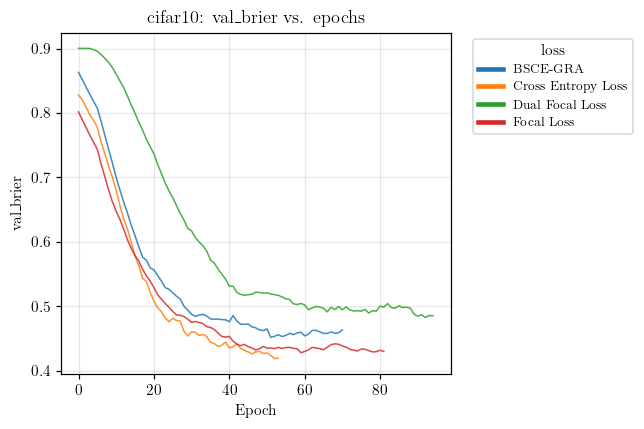

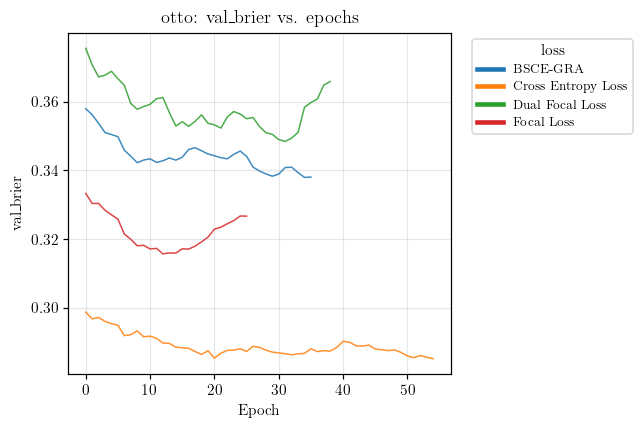

In [56]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'AltLoss'

mask = hist_df['method'].isin(['Baseline', 'AltLoss'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, hue='loss', save_pdf=True, path_to_dir=aggregated_path)


RegAug

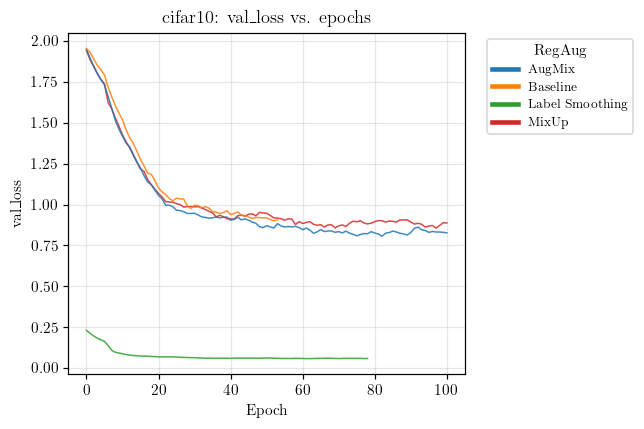

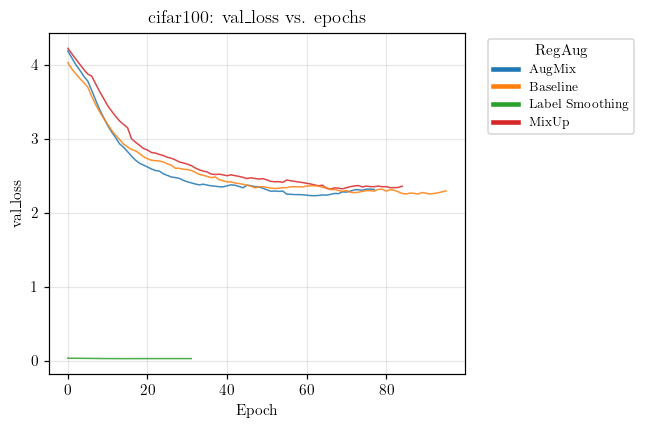

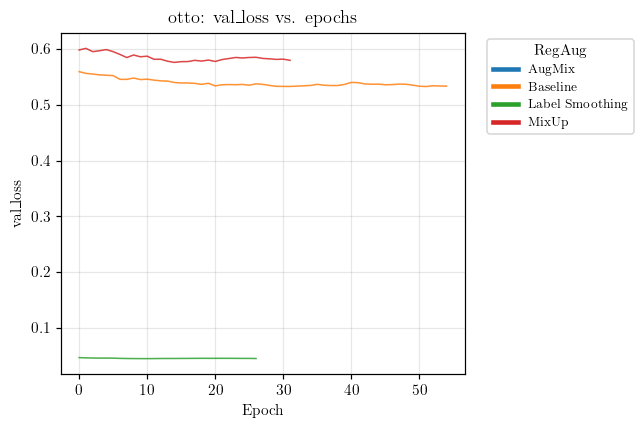

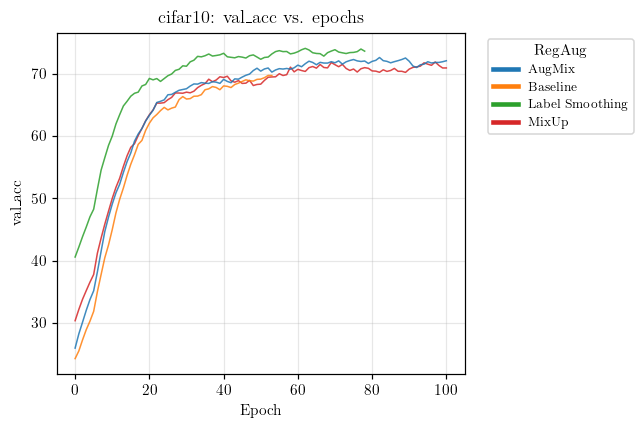

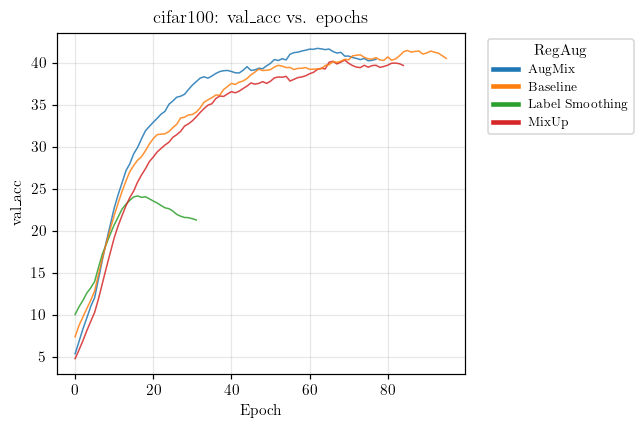

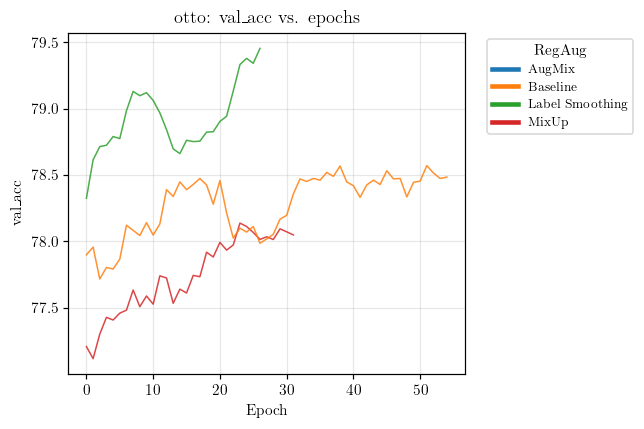

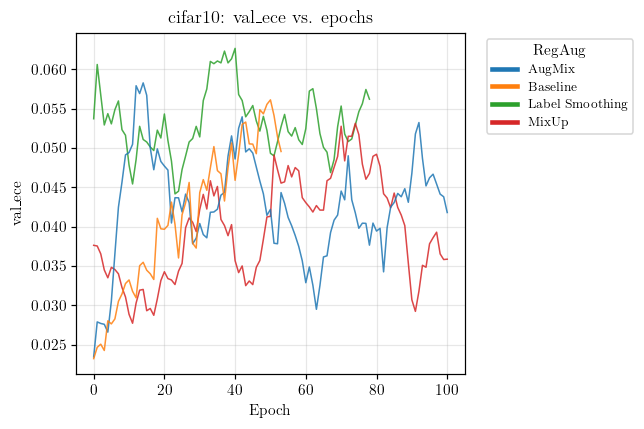

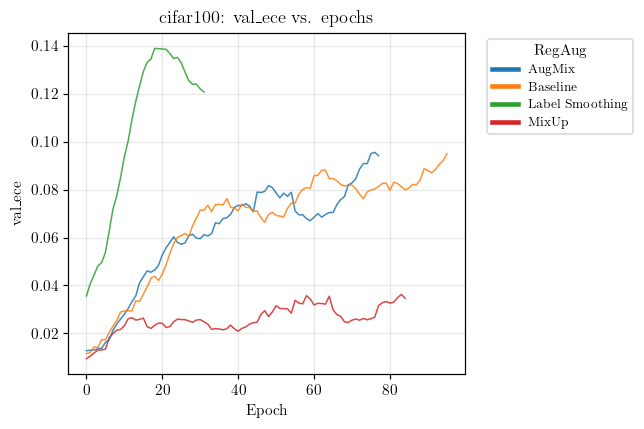

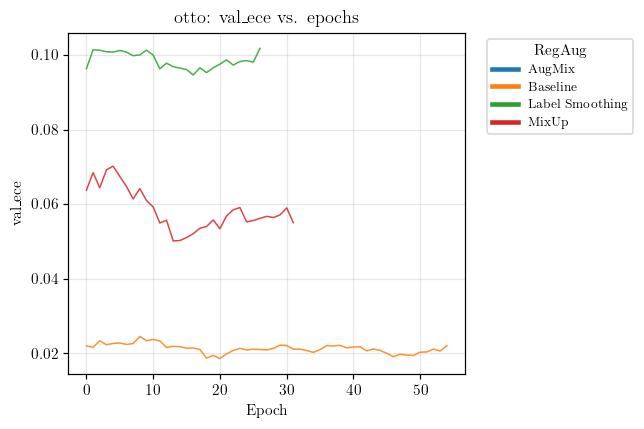

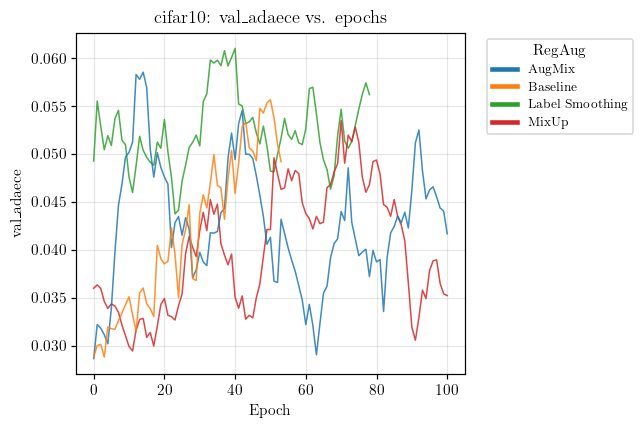

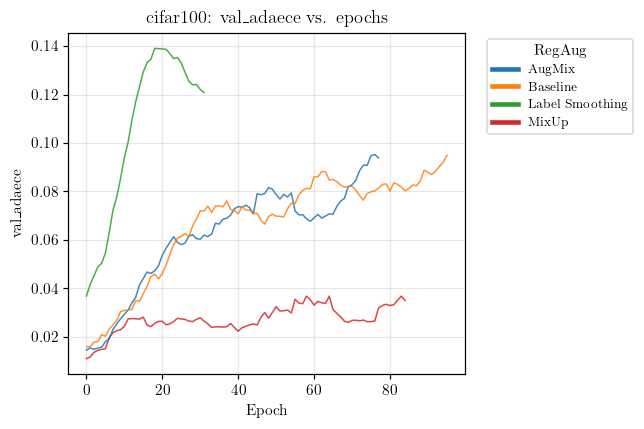

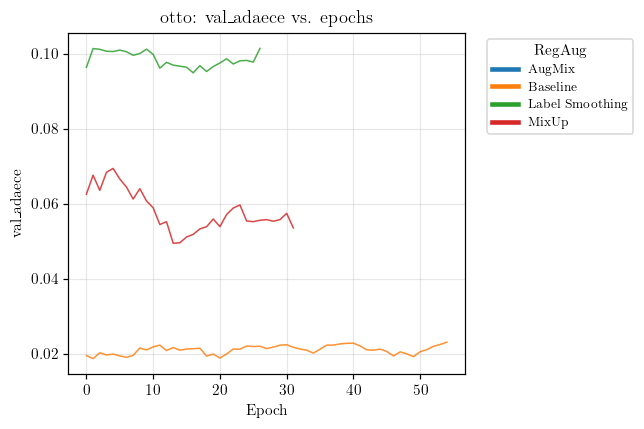

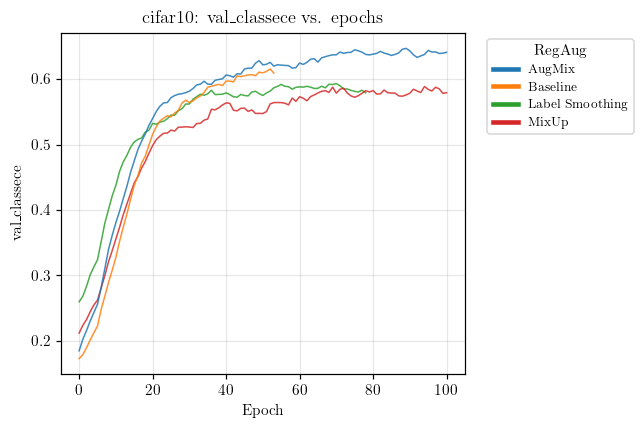

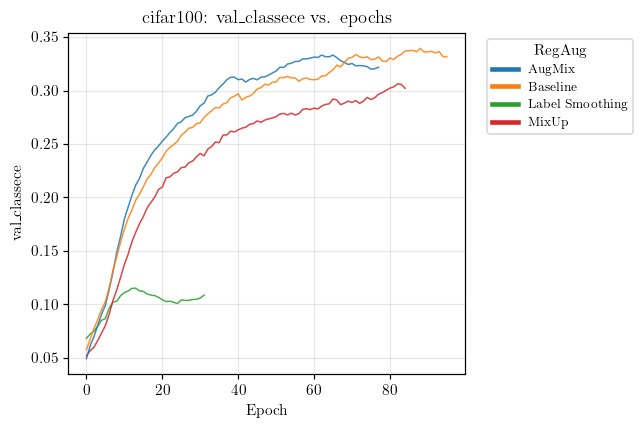

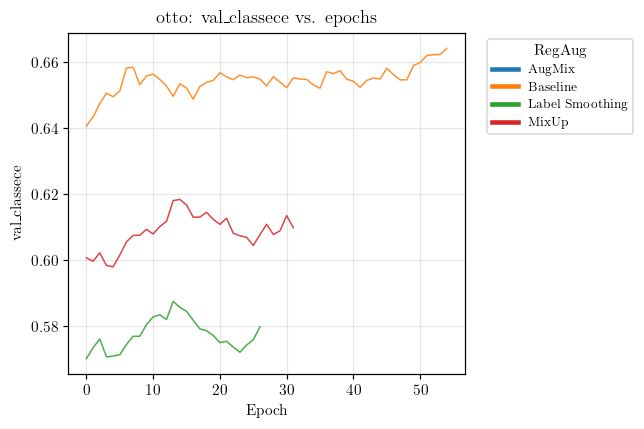

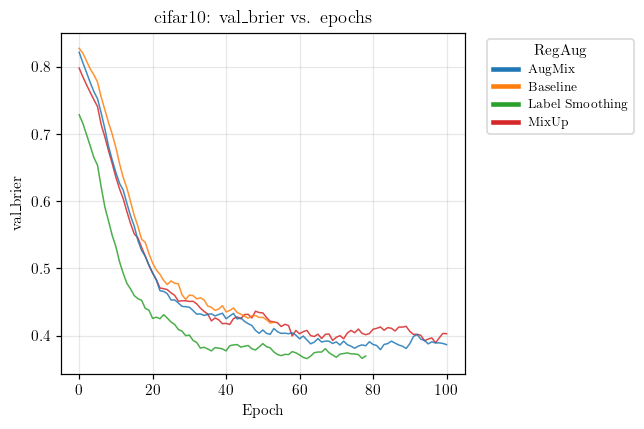

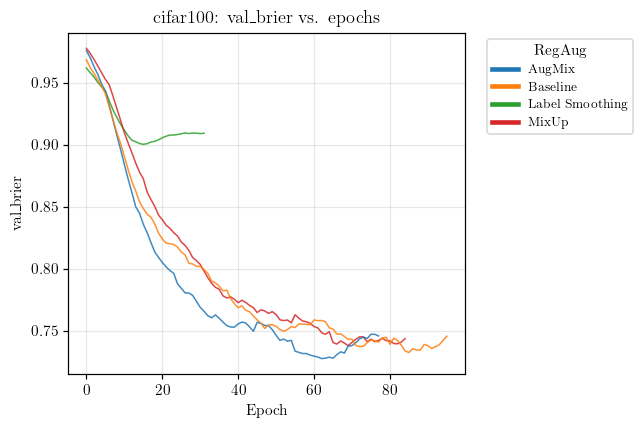

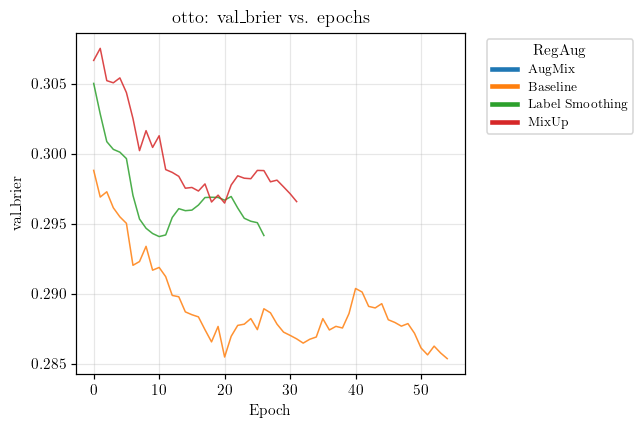

In [58]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'RegAug'

mask = hist_df['method'].isin(['Baseline', 'RegAug'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, hue='RegAug', save_pdf=True, path_to_dir=aggregated_path)

In [66]:
hist_df['Mix Methods'].unique()

['MixUp+dual_focal', 'Baseline+bsce_gra', 'Label Smoothing+bsce_gra', 'Label Smoothing+dual_focal', 'Label Smoothing+cross_entropy', ..., 'MixUp+focal', 'Baseline+dual_focal', 'AugMix+focal', 'AugMix+bsce_gra', 'MixUp+bsce_gra']
Length: 16
Categories (16, object): ['AugMix+bsce_gra', 'AugMix+cross_entropy', 'AugMix+dual_focal', 'AugMix+focal', ..., 'MixUp+bsce_gra', 'MixUp+cross_entropy', 'MixUp+dual_focal', 'MixUp+focal']

Посмотрим на миксованные методы

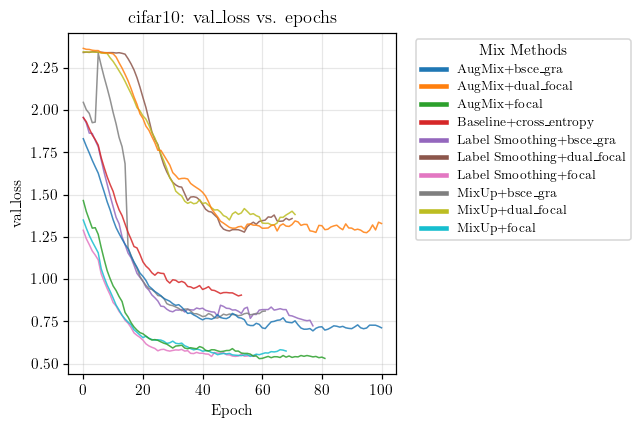

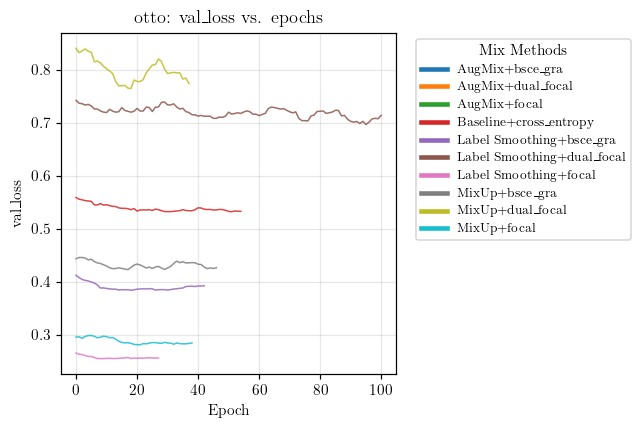

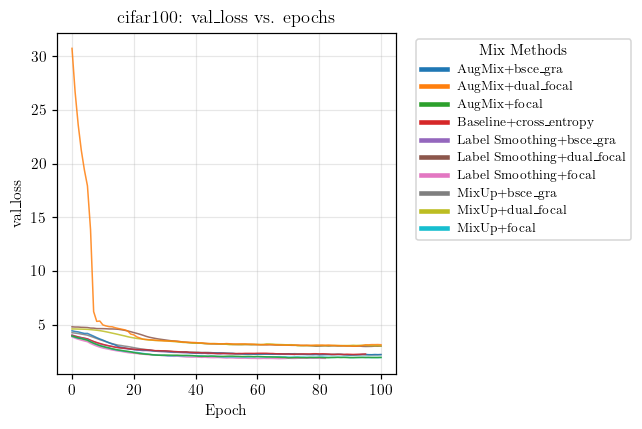

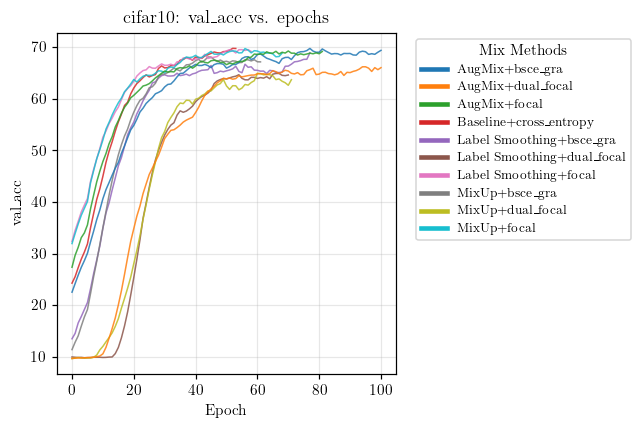

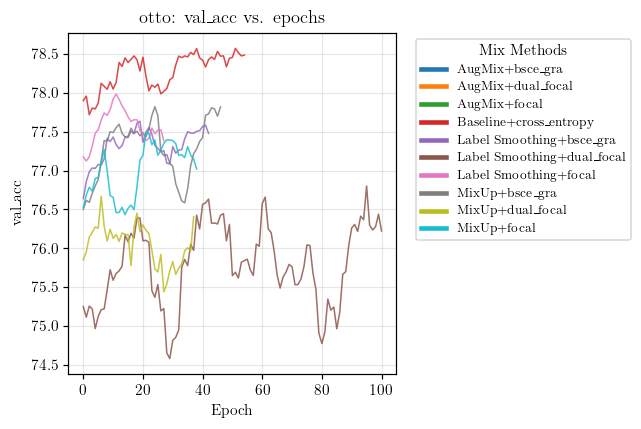

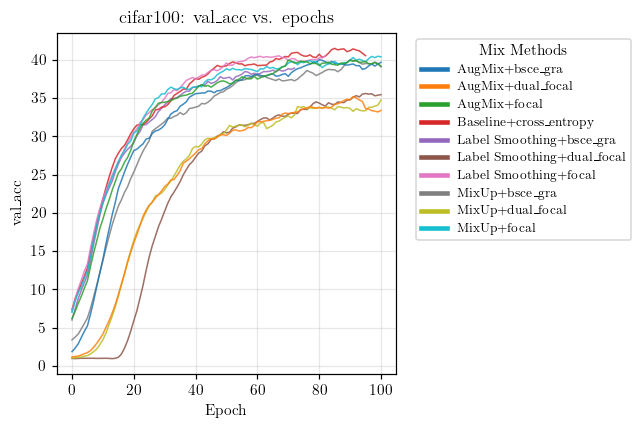

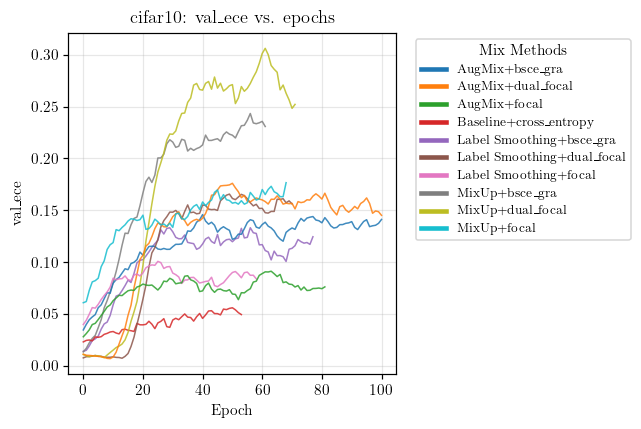

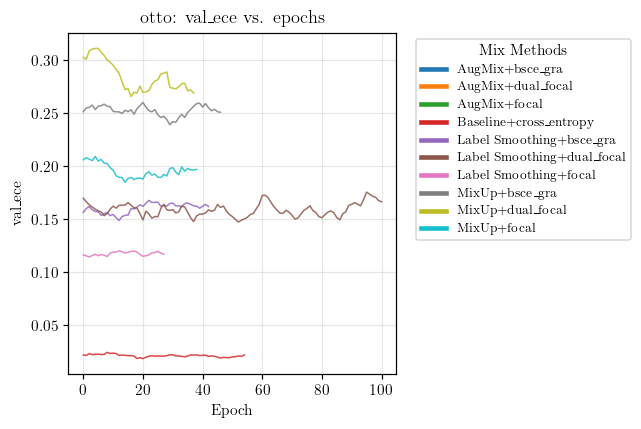

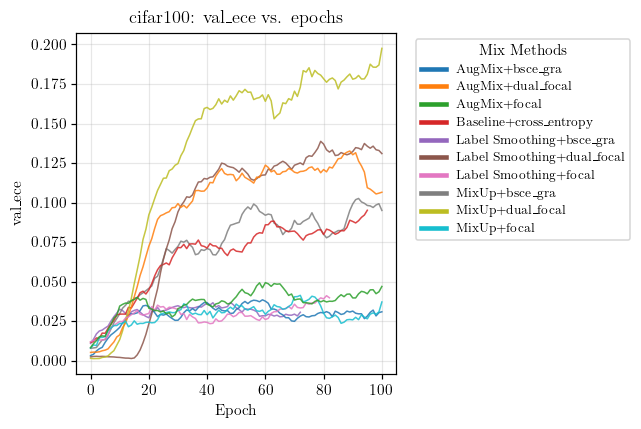

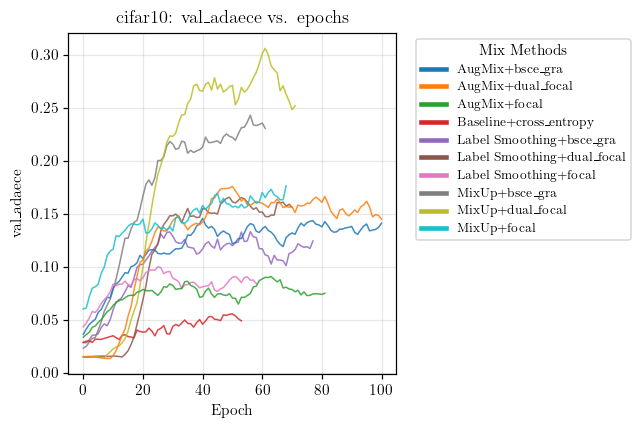

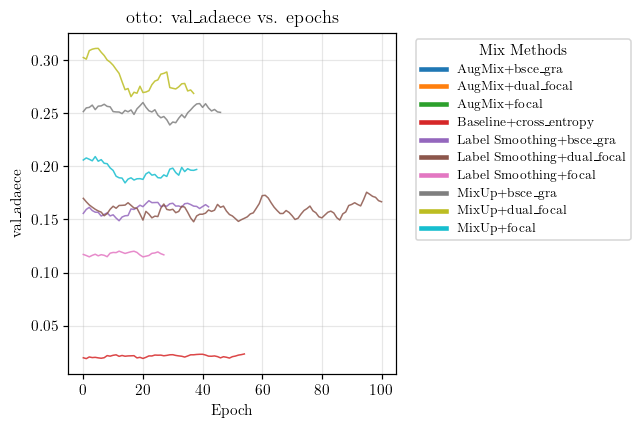

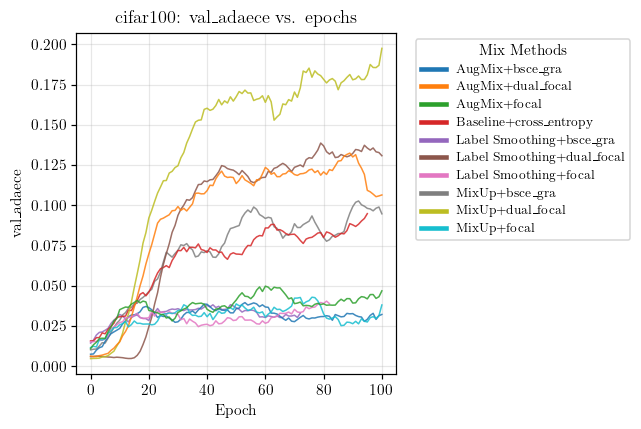

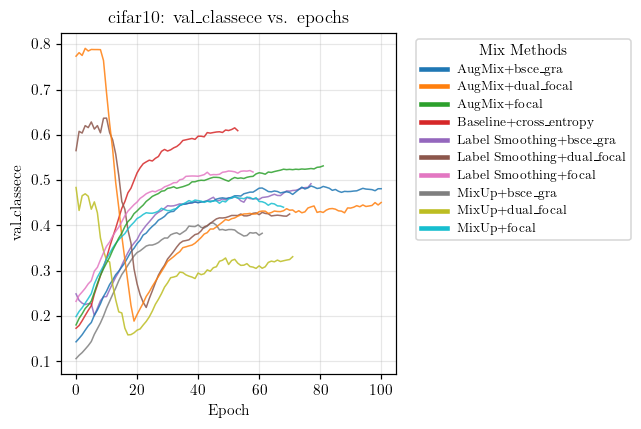

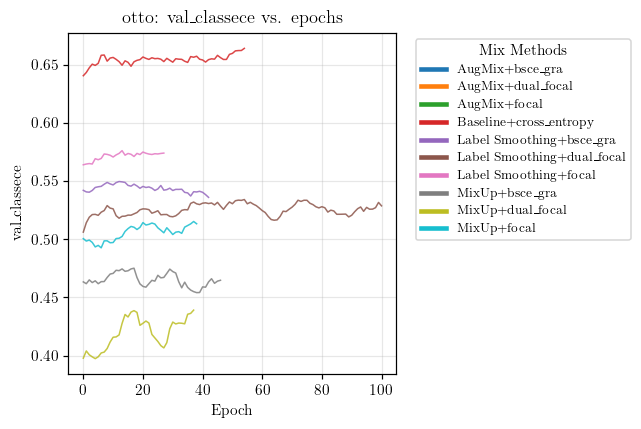

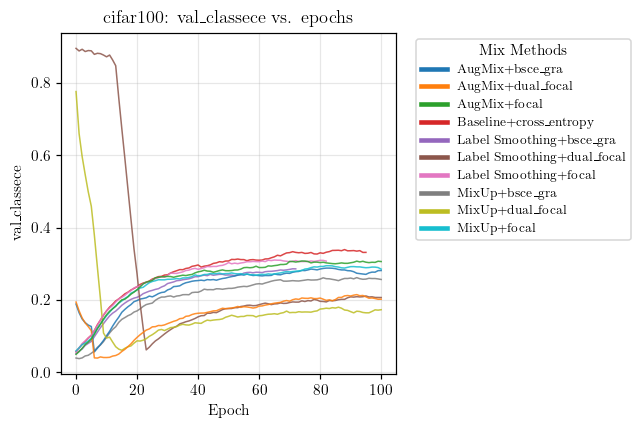

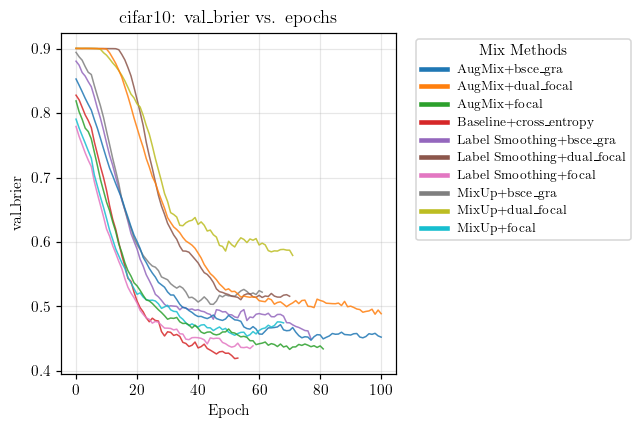

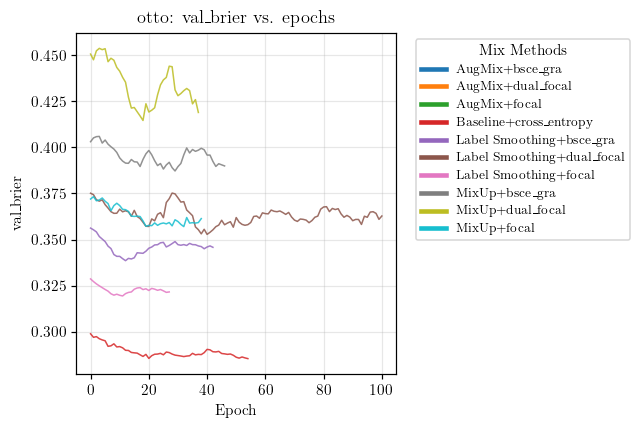

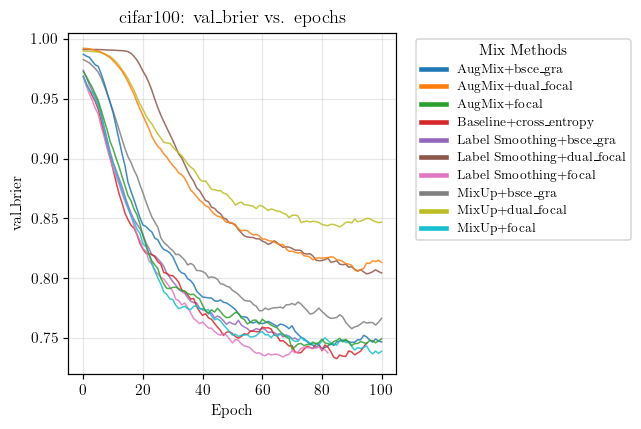

In [82]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'mixed'

mask_baseline = hist_df['Mix Methods'].str.contains('Baseline', na=False)
mask_ce       = hist_df['Mix Methods'].str.contains('cross_entropy', na=False)
to_drop = mask_baseline ^ mask_ce  
sub  = hist_df[~to_drop].copy()
sub["Mix Methods"] = sub["Mix Methods"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, hue='Mix Methods', max_epoch=100, save_pdf=True, path_to_dir=aggregated_path)

Теперь смотрим таблицу с калибровкой и без

In [113]:
from src.utils_plot import build_summary_table

summary_df = build_summary_table(test_df, calib_df)
summary_df

LaTeX table saved to table_calibration_summary.tex


<string>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


ece                                  adaece  \
calibrator                        pre        TS     Platt        IR       pre   
dataset  method_name                                                            
cifar10  AugMix              0.034155  0.032365  0.032692  0.041798  0.033997   
         Bsce-Gra            0.134094  0.049780  0.026179  0.039322  0.133930   
         Cross Entropy Loss  0.010877  0.017131  0.022046  0.021234  0.010893   
         Dual Focal Loss     0.191940  0.055051  0.016768  0.036100  0.191836   
         Focal Loss          0.113463  0.055299  0.014342  0.024604  0.113201   
         Label Smoothing     0.055479  0.031609  0.045455  0.033024  0.055181   
         MixUp               0.042814  0.018652  0.032506  0.009980  0.043310   
cifar100 AugMix              0.056923  0.062481  0.185136  0.080001  0.056923   
         Bsce-Gra            0.035378  0.024937  0.157102  0.046697  0.035213   
         Cross Entropy Loss  0.074801  0.081269  0.194102  0.097948  0.074974   
         Dual Focal Loss     0.144489  0.049943  0.106149  0.037723  0.144489   
         Focal Loss          0.026309  0.042827  0.173535  0.068028  0.025842   
         Label Smoothing     0.131181  0.099529  0.065080  0.021071  0.131181   
         MixUp               0.009575  0.028910  0.176763  0.062202  0.010737   
otto     AugMix                   NaN       NaN       NaN       NaN       NaN   
         Bsce-Gra            0.161082  0.075827  0.028082  0.028086  0.160917   
         Cross Entropy Loss  0.021862  0.021679  0.018148  0.025921  0.020134   
         Dual Focal Loss     0.145911  0.048564  0.023176  0.028684  0.144529   
         Focal Loss          0.120016  0.059053  0.025213  0.017432  0.119023   
         Label Smoothing     0.090535  0.029816  0.022758  0.031390  0.089293   
         MixUp               0.031688  0.026502  0.028222  0.019688  0.031979   

                                                           
calibrator                         TS     Platt        IR  
dataset  method_name                                       
cifar10  AugMix              0.032049  0.032706  0.041083  
         Bsce-Gra            0.048659  0.028625  0.036529  
         Cross Entropy Loss  0.014280  0.022177  0.024059  
         Dual Focal Loss     0.055051  0.015392  0.038624  
         Focal Loss          0.053121  0.018400  0.033264  
         Label Smoothing     0.030017  0.049679  0.032815  
         MixUp               0.017546  0.031448  0.011589  
cifar100 AugMix              0.062481  0.185136  0.080000  
         Bsce-Gra            0.021961  0.157102  0.046362  
         Cross Entropy Loss  0.081047  0.194102  0.097220  
         Dual Focal Loss     0.049943  0.106149  0.037447  
         Focal Loss          0.042827  0.173535  0.068028  
         Label Smoothing     0.099529  0.064892  0.024857  
         MixUp               0.028813  0.176763  0.062202  
otto     AugMix                   NaN       NaN       NaN  
         Bsce-Gra            0.075425  0.028585  0.032227  
         Cross Entropy Loss  0.015013  0.016063  0.022945  
         Dual Focal Loss     0.047413  0.025355  0.021067  
         Focal Loss          0.057878  0.025741  0.020184  
         Label Smoothing     0.028351  0.024637  0.025865  
         MixUp               0.021980  0.025380  0.018240

In [ ]:
pivot = test_df.pivot(
    index=['dataset', 'loss'],
    columns='RegAug',
    values='ece',
).fillna('-')
pivot.to_latex()

RegAug                         AugMix  Baseline  Label Smoothing     MixUp
dataset  loss                                                             
cifar10  BSCE-GRA            0.147111  0.134094         0.193210  0.198688
         Cross Entropy Loss  0.034155  0.010877         0.055479  0.042814
         Dual Focal Loss     0.199248  0.191940         0.196783  0.224937
         Focal Loss          0.116708  0.113463         0.090301  0.218594
cifar100 BSCE-GRA            0.040669  0.035378         0.048289  0.131101
         Cross Entropy Loss  0.056923  0.074801         0.131181  0.009575
         Dual Focal Loss     0.149946  0.144489         0.139909  0.216751
         Focal Loss          0.026076  0.026309         0.017681  0.083157
otto     BSCE-GRA                   -  0.161082         0.157187  0.218717
         Cross Entropy Loss         -  0.021862         0.090535  0.031688
         Dual Focal Loss            -  0.145911         0.165336  0.238389
         Focal Loss                 -  0.120016         0.111910  0.196826

In [ ]:
latex = pivot.to_latex(
    caption='ECE vs. Loss и RegAug для cifar10',
    label='tab:ece_cifar10',
    float_format="%.3f",
    na_rep='-',
    index_names=True,      
    column_format='l' + 'r'*df.shape[1],  # первая колонка слева выравн. по l, остальные — по r
    longtable=False,       # True использует longtable, False обычный табличный float
    escape=False           
)
print(latex)

\begin{table}
\caption{ECE vs. Loss и RegAug для cifar10}
\label{tab:ece_cifar10}
\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
 & RegAug & AugMix & Baseline & Label Smoothing & MixUp \\
dataset & loss &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{cifar10} & BSCE-GRA & 0.147 & 0.134 & 0.193 & 0.199 \\
 & Cross Entropy Loss & 0.034 & 0.011 & 0.055 & 0.043 \\
 & Dual Focal Loss & 0.199 & 0.192 & 0.197 & 0.225 \\
 & Focal Loss & 0.117 & 0.113 & 0.090 & 0.219 \\
\cline{1-6}
\multirow[t]{4}{*}{cifar100} & BSCE-GRA & 0.041 & 0.035 & 0.048 & 0.131 \\
 & Cross Entropy Loss & 0.057 & 0.075 & 0.131 & 0.010 \\
 & Dual Focal Loss & 0.150 & 0.144 & 0.140 & 0.217 \\
 & Focal Loss & 0.026 & 0.026 & 0.018 & 0.083 \\
\cline{1-6}
\multirow[t]{4}{*}{otto} & BSCE-GRA & - & 0.161 & 0.157 & 0.219 \\
 & Cross Entropy Loss & - & 0.022 & 0.091 & 0.032 \\
 & Dual Focal Loss & - & 0.146 & 0.165 & 0.238 \\
 & Focal Loss & - & 0.120 & 0.112 & 0.197 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}

